<a href="https://colab.research.google.com/github/humairahs/ECG-arrythmia/blob/main/ecg_arrythmia_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABOUT
- Objective: classify arrythmia based on ECG data using CNN-LSTM. CNN allows to extract spatial feature; LSTM for temporal pattern recognition
- Dataset: MIT-BIH arrythmia database (accessed through Kaggle https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data). The dataset is already splitted into train & test set. Class categories: [0, 1, 2, 3, 4] corresponds to [Normal, Supraventricular, Ventricular, Fusion, Unclassiable]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayyidahhumairah","key":"1975755319af0389e88b64ffc8e56692"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# download dataset and auto-unzip into target folder
!kaggle datasets download -d shayanfazeli/heartbeat -p /content/dataset/heartbeat --unzip
!ls -lha /content/dataset/heartbeat


Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
  0% 0.00/98.8M [00:00<?, ?B/s]
100% 98.8M/98.8M [00:00<00:00, 1.77GB/s]
total 556M
drwxr-xr-x 2 root root 4.0K Dec  3 01:18 .
drwxr-xr-x 3 root root 4.0K Dec  3 01:18 ..
-rw-r--r-- 1 root root  99M Dec  3 01:18 mitbih_test.csv
-rw-r--r-- 1 root root 393M Dec  3 01:18 mitbih_train.csv
-rw-r--r-- 1 root root  48M Dec  3 01:18 ptbdb_abnormal.csv
-rw-r--r-- 1 root root  19M Dec  3 01:18 ptbdb_normal.csv


# Handling the data

In [ ]:
# Loading train data
df_train = pd.read_csv('/content/dataset/heartbeat/mitbih_train.csv', header=None)
print(f"Train data loaded: {df_train.shape}")

# Loading test data
df_test = pd.read_csv('/content/dataset/heartbeat/mitbih_test.csv', header=None)
print(f"Test data loaded: {df_test.shape}")

Train data loaded: (87554, 188)
Test data loaded: (21892, 188)


In [ ]:
# Separate features (X) and labels (y)
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values.astype(int)

X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values.astype(int)

In [ ]:
# Display class distribution, we can see that the dataset is imbalanced
print("\n=== Class Distribution in Training Set ===")
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unclassifiable']
for i in range(5):
    count = np.sum(y_train == i)
    percentage = 100 * count / len(y_train)
    print(f"Class {i} ({class_names[i]}): {count} ({percentage:.2f}%)")

print("\n=== Class Distribution in Test Set ===")
for i in range(5):
    count = np.sum(y_test == i)
    percentage = 100 * count / len(y_test)
    print(f"Class {i} ({class_names[i]}): {count} ({percentage:.2f}%)")


=== Class Distribution in Training Set ===
Class 0 (Normal): 72471 (82.77%)
Class 1 (Supraventricular): 2223 (2.54%)
Class 2 (Ventricular): 5788 (6.61%)
Class 3 (Fusion): 641 (0.73%)
Class 4 (Unclassifiable): 6431 (7.35%)

=== Class Distribution in Test Set ===
Class 0 (Normal): 18118 (82.76%)
Class 1 (Supraventricular): 556 (2.54%)
Class 2 (Ventricular): 1448 (6.61%)
Class 3 (Fusion): 162 (0.74%)
Class 4 (Unclassifiable): 1608 (7.35%)


In [ ]:
print("\n=== Data Quality Analysis ===")

# 1. Check for missing values
print("\n1. Missing Values Check:")
print(f"Training set - Missing values: {df_train.isnull().sum().sum()}")
print(f"Test set - Missing values: {df_test.isnull().sum().sum()}")

if df_train.isnull().sum().sum() > 0:
    print("WARNING: Found missing values in training data!")
    print(df_train.isnull().sum()[df_train.isnull().sum() > 0])

if df_test.isnull().sum().sum() > 0:
    print("WARNING: Found missing values in test data!")
    print(df_test.isnull().sum()[df_test.isnull().sum() > 0])


=== Data Quality Analysis ===

1. Missing Values Check:
Training set - Missing values: 0
Test set - Missing values: 0


In [ ]:
# 2. Check for duplicates
print("\n2. Duplicate Records Check:")
train_duplicates = df_train.duplicated().sum()
test_duplicates = df_test.duplicated().sum()
print(f"Training set - Duplicate rows: {train_duplicates} ({100*train_duplicates/len(df_train):.2f}%)")
print(f"Test set - Duplicate rows: {test_duplicates} ({100*test_duplicates/len(df_test):.2f}%)")


2. Duplicate Records Check:
Training set - Duplicate rows: 0 (0.00%)
Test set - Duplicate rows: 0 (0.00%)


In [ ]:
# Remove duplicates if found
if train_duplicates > 0:
    print(f"\nRemoving {train_duplicates} duplicate rows from training set...")
    df_train = df_train.drop_duplicates()
    X_train = df_train.iloc[:, :-1].values
    y_train = df_train.iloc[:, -1].values.astype(int)
    print(f"New training set shape: {df_train.shape}")

if test_duplicates > 0:
    print(f"\nRemoving {test_duplicates} duplicate rows from test set...")
    df_test = df_test.drop_duplicates()
    X_test = df_test.iloc[:, :-1].values
    y_test = df_test.iloc[:, -1].values.astype(int)
    print(f"New test set shape: {df_test.shape}")

In [ ]:
# 3. Check for infinite values
print("\n3. Infinite Values Check:")
train_inf = np.isinf(X_train).sum()
test_inf = np.isinf(X_test).sum()
print(f"Training set - Infinite values: {train_inf}")
print(f"Test set - Infinite values: {test_inf}")

if train_inf > 0 or test_inf > 0:
    print("WARNING: Found infinite values in data!")


3. Infinite Values Check:
Training set - Infinite values: 0
Test set - Infinite values: 0


In [ ]:
# 4. Check data ranges
print("\n4. Data Range Analysis:")
print(f"Training set - Min: {X_train.min():.4f}, Max: {X_train.max():.4f}, Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")
print(f"Test set - Min: {X_test.min():.4f}, Max: {X_test.max():.4f}, Mean: {X_test.mean():.4f}, Std: {X_test.std():.4f}")


4. Data Range Analysis:
Training set - Min: 0.0000, Max: 1.0000, Mean: 0.1743, Std: 0.2263
Test set - Min: 0.0000, Max: 1.0000, Mean: 0.1735, Std: 0.2256


In [ ]:
# 5. Check label validity
print("\n5. Label Validation:")
unique_train_labels = np.unique(y_train)
unique_test_labels = np.unique(y_test)
print(f"Training set - Unique labels: {unique_train_labels}")
print(f"Test set - Unique labels: {unique_test_labels}")

if not np.array_equal(unique_train_labels, np.array([0, 1, 2, 3, 4])):
    print("WARNING: Unexpected labels found in training set!")

if not np.array_equal(unique_test_labels, np.array([0, 1, 2, 3, 4])):
    print("WARNING: Unexpected labels found in test set!")


5. Label Validation:
Training set - Unique labels: [0 1 2 3 4]
Test set - Unique labels: [0 1 2 3 4]


In [ ]:
# Display class distribution
print("\n=== Class Distribution (Imbalance Analysis) ===")
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unclassifiable']

# Calculate counts for both sets
train_counts = [np.sum(y_train == i) for i in range(5)]
test_counts = [np.sum(y_test == i) for i in range(5)]

print("\nTraining Set:")
for i in range(5):
    count = train_counts[i]
    percentage = 100 * count / len(y_train)
    print(f"  Class {i} ({class_names[i]:20s}): {count:6d} samples ({percentage:5.2f}%)")

print("\nTest Set:")
for i in range(5):
    count = test_counts[i]
    percentage = 100 * count / len(y_test)
    print(f"  Class {i} ({class_names[i]:20s}): {count:6d} samples ({percentage:5.2f}%)")


=== Class Distribution (Imbalance Analysis) ===

Training Set:
  Class 0 (Normal              ):  72471 samples (82.77%)
  Class 1 (Supraventricular    ):   2223 samples ( 2.54%)
  Class 2 (Ventricular         ):   5788 samples ( 6.61%)
  Class 3 (Fusion              ):    641 samples ( 0.73%)
  Class 4 (Unclassifiable      ):   6431 samples ( 7.35%)

Test Set:
  Class 0 (Normal              ):  18118 samples (82.76%)
  Class 1 (Supraventricular    ):    556 samples ( 2.54%)
  Class 2 (Ventricular         ):   1448 samples ( 6.61%)
  Class 3 (Fusion              ):    162 samples ( 0.74%)
  Class 4 (Unclassifiable      ):   1608 samples ( 7.35%)


In [ ]:
# Calculate imbalance ratio
max_class_count = max(train_counts)
min_class_count = min(train_counts)
imbalance_ratio = max_class_count / min_class_count
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 10:
    print("Dataset is highly imbalanced - Class weighting will be applied")


Imbalance Ratio: 113.06:1
Dataset is highly imbalanced - Class weighting will be applied


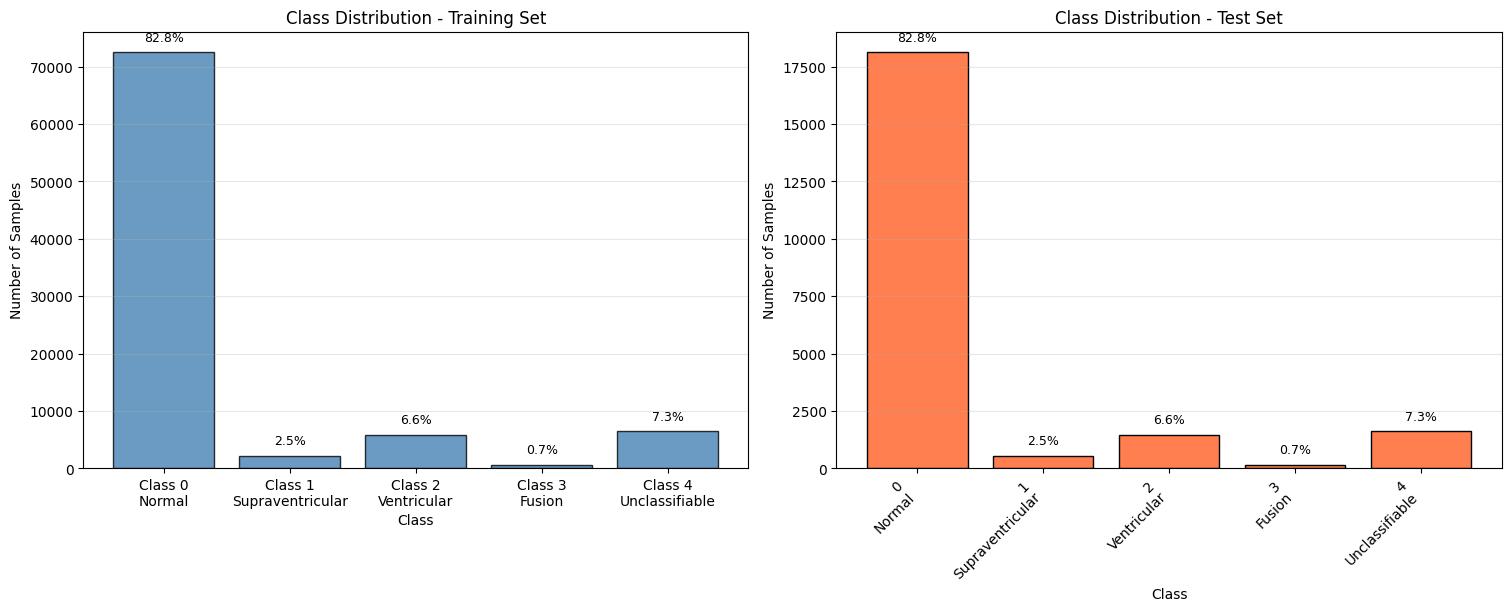

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

train_counts = [int(np.sum(y_train == i)) for i in range(5)]
ax1.bar(range(5), train_counts, color='steelblue', edgecolor='black', alpha=0.8)
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Class Distribution - Training Set')
ax1.set_xticks(range(5))
ax1.set_xticklabels([f'Class {i}\n{class_names[i]}' for i in range(5)], rotation=0, fontsize=10)
ax1.grid(axis='y', alpha=0.3)

ymax_train = max(train_counts) if train_counts else 1
offset_train = ymax_train * 0.02
for i, count in enumerate(train_counts):
    pct = 100 * count / len(y_train) if len(y_train) else 0
    ax1.text(i, count + offset_train, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

test_counts = [int(np.sum(y_test == i)) for i in range(5)]
ax2.bar(range(5), test_counts, color='coral', edgecolor='black')
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Class Distribution - Test Set')
ax2.set_xticks(range(5))
ax2.set_xticklabels([f'{i}\n{class_names[i]}' for i in range(5)], rotation=45, ha='right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

ymax_test = max(test_counts) if test_counts else 1
offset_test = ymax_test * 0.02
for i, count in enumerate(test_counts):
    pct = 100 * count / len(y_test) if len(y_test) else 0
    ax2.text(i, count + offset_test, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.show()


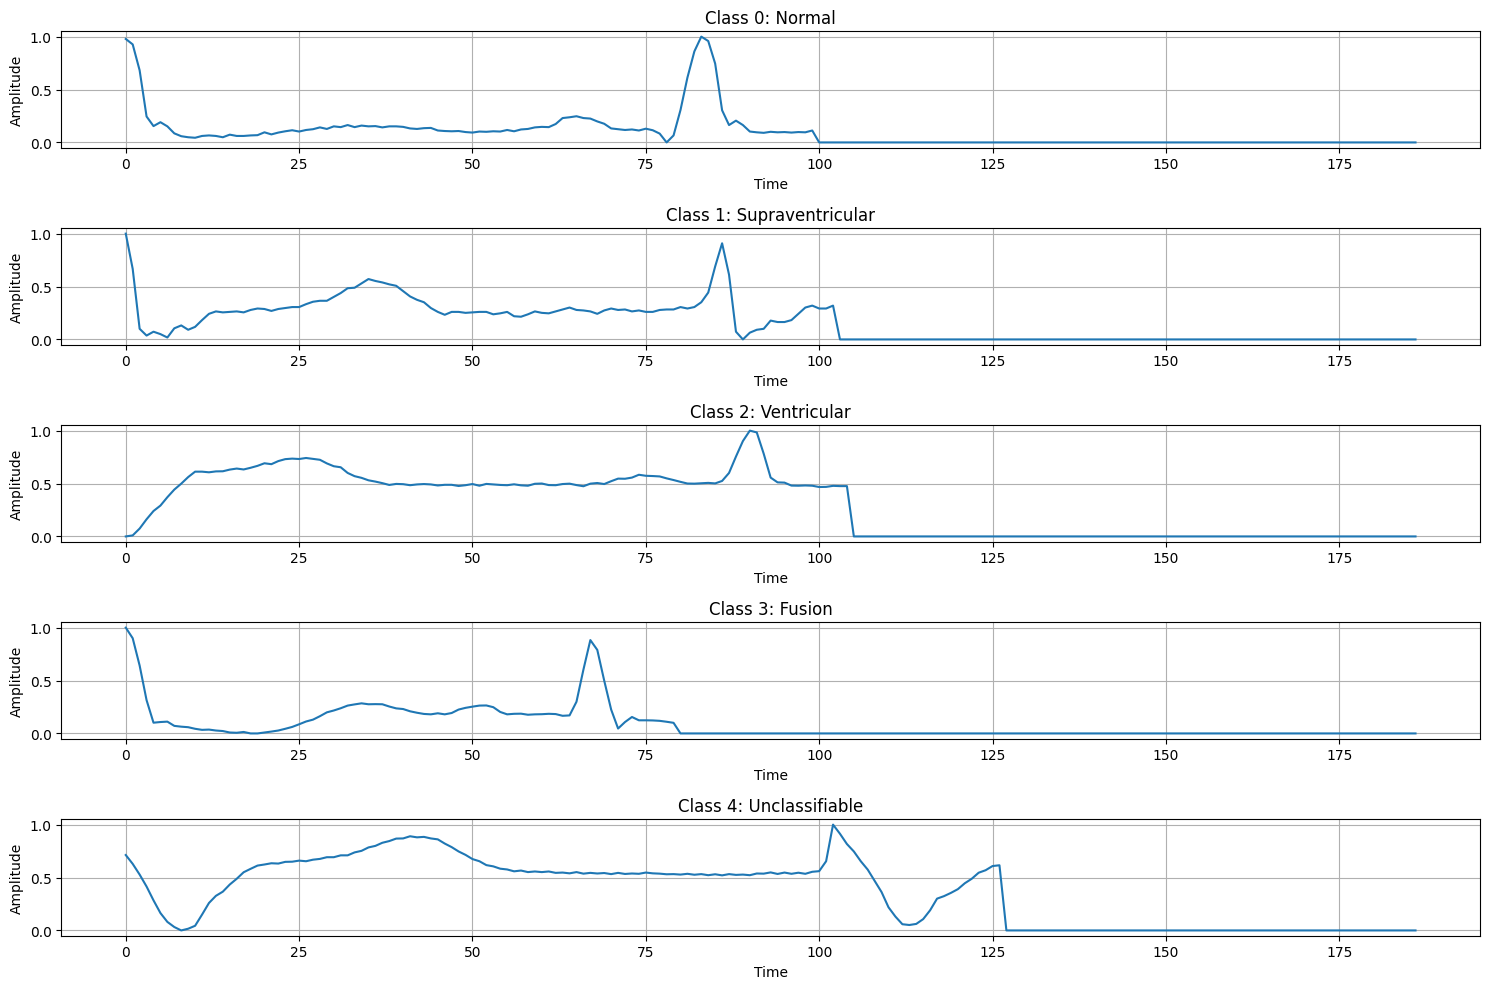

In [ ]:
# Visualize sample ECG signals from each class
fig, axes = plt.subplots(5, 1, figsize=(15, 10))
for i in range(5):
    # Find first signal from class i
    idx = np.where(y_train == i)[0][0]
    axes[i].plot(X_train[idx])
    axes[i].set_title(f'Class {i}: {class_names[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

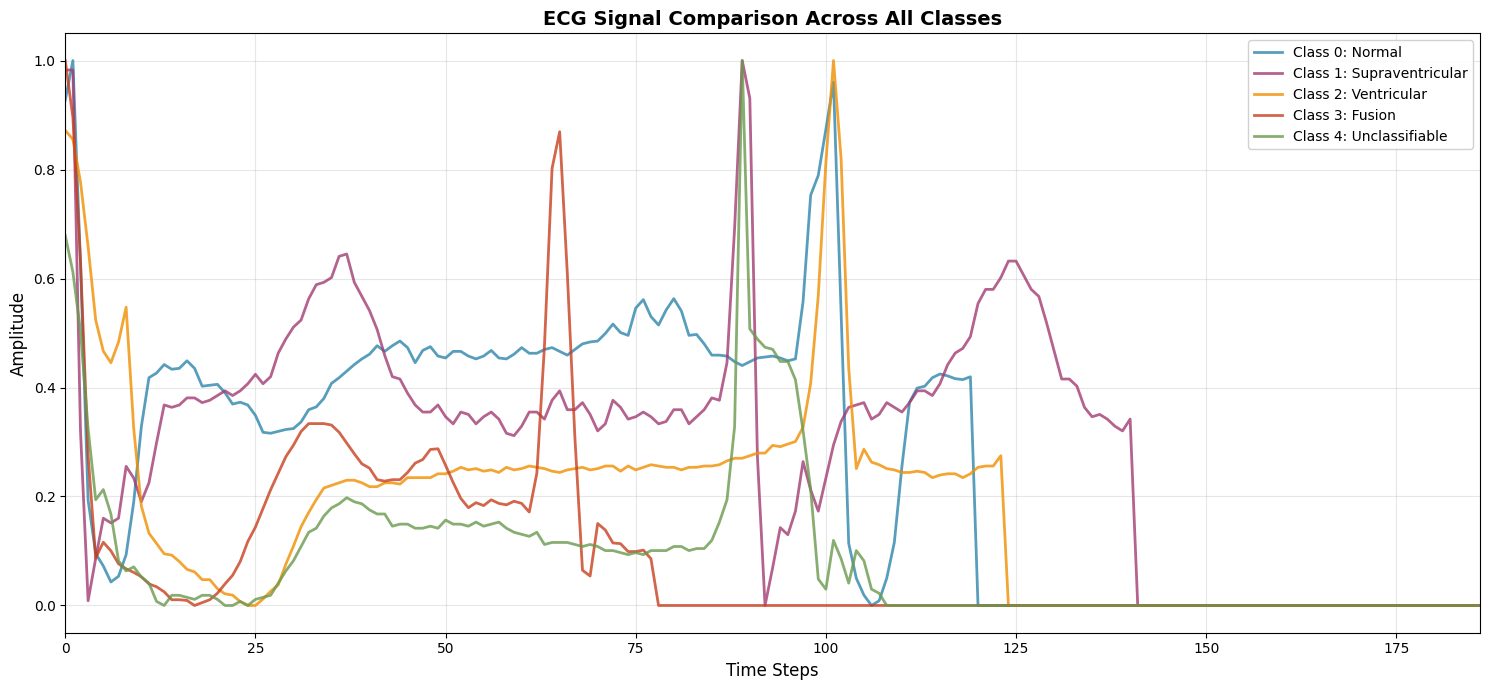

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize sample ECG signals from each class (overlapping)
plt.figure(figsize=(15, 7))

# Define colors for each class
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

for i in range(5):
    # Find all signals from class i and pick the 5th sample
    class_indices = np.where(y_train == i)[0]
    # Use 5th signal if available, otherwise use first
    idx = class_indices[5] if len(class_indices) > 5 else class_indices[0]

    plt.plot(X_train[idx], linewidth=2, color=colors[i],
             label=f'Class {i}: {class_names[i]}', alpha=0.8)

plt.title('ECG Signal Comparison Across All Classes', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.xlim(0, 186)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

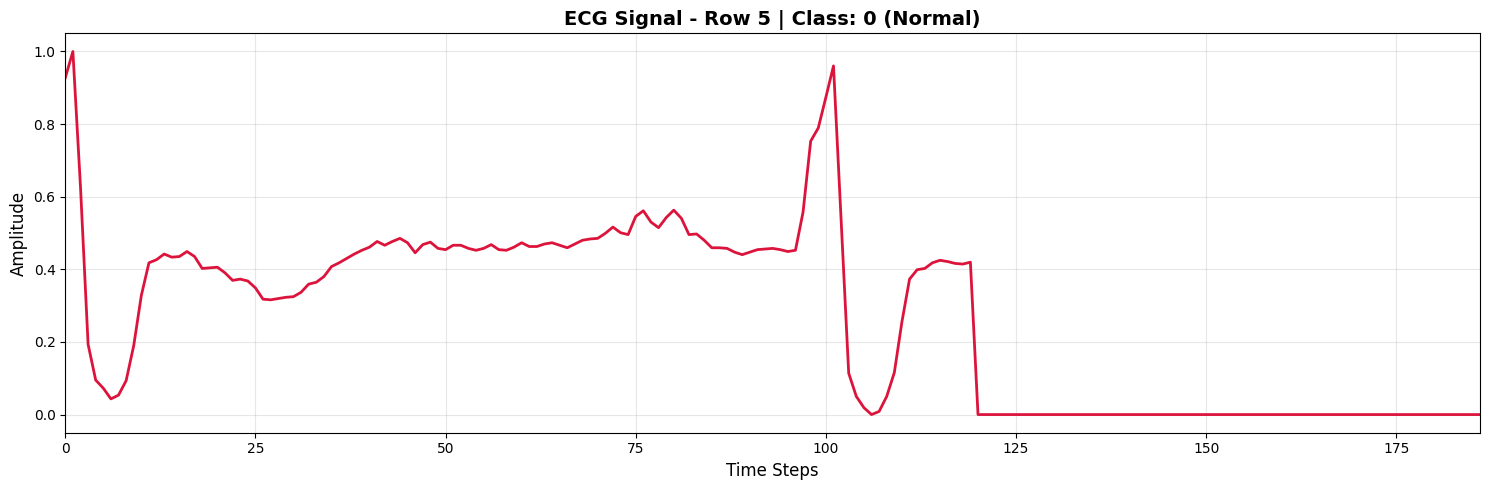

In [ ]:
# Visualize single ECG signal - 5th row from entire dataset
sample_idx = 5
sample_signal = X_train[sample_idx]
sample_label = y_train[sample_idx]

plt.figure(figsize=(15, 5))
plt.plot(sample_signal, linewidth=2, color='crimson')
plt.title(f'ECG Signal - Row {sample_idx} | Class: {sample_label} ({class_names[sample_label]})',
          fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 186)
plt.tight_layout()
plt.show()


## Prepare data

In [ ]:
# Normalize data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Convert to PyTorch Dataset
class ECGDataset(Dataset):
    """Custom PyTorch Dataset for ECG signals"""
    def __init__(self, X, y):
        # Add channel dimension for CNN (batch, channels, length)
        self.X = torch.FloatTensor(X).unsqueeze(1)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# Create DataLoaders
train_dataset = ECGDataset(X_train_scaled, y_train)
test_dataset = ECGDataset(X_test_scaled, y_test)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# helper

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate(model, dataloader, criterion):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

# CNN LSTM Modle

In [ ]:
class CNN_LSTM(nn.Module):
    """
    Hybrid CNN-LSTM architecture for ECG signal classification

    CNN layers: Extract spatial features from signals
    LSTM layers: Capture temporal dependencies
    """
    def __init__(self, n_classes=5, input_channels=1, input_length=187):
        super(CNN_LSTM, self).__init__()

        # CNN blocks
        # Conv Block 1
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.2)

        # Conv Block 2
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.2)

        # Conv Block 3
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.2)

        # Calculate size after convolutions
        # After 3 MaxPool layers with kernel_size=2: input_length // (2^3)
        lstm_input_size = input_length // 8
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=128,  # number of CNN feature maps
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True  # Bidirectional LSTM for better performance
        )

        # Fully Connected layers
        # Bidirectional LSTM outputs 2 * hidden_size
        self.fc1 = nn.Linear(128, 64)  # 64 * 2 = 128
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # CNN part
        # x shape: (batch, 1, length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Prepare for LSTM: (batch, channels, length) -> (batch, length, channels)
        x = x.permute(0, 2, 1)

        # LSTM part
        # x shape: (batch, seq_len, features)
        lstm_out, (hidden, cell) = self.lstm(x)

        # Take last output from LSTM
        x = lstm_out[:, -1, :]

        # Fully connected
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x


In [ ]:
model = CNN_LSTM(n_classes=5, input_channels=1, input_length=187)


In [ ]:
# Calculate class weights for imbalanced data
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"\nClass weights for loss function:")
for i, weight in enumerate(class_weights):
    print(f"  Class {i} ({class_names[i]}): {weight:.4f}")


Class weights for loss function:
  Class 0 (Normal): 0.0293
  Class 1 (Supraventricular): 0.9563
  Class 2 (Ventricular): 0.3673
  Class 3 (Fusion): 3.3165
  Class 4 (Unclassifiable): 0.3306


In [ ]:
# CrossEntropyLoss with weights for balanced classes
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
num_epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

In [ ]:
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
print("="*60)

for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    # Validation
    val_loss, val_acc = validate(model, test_loader, criterion)

    # Save history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_ecg_model.pth')
        print(f'{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.2f}% {val_loss:<12.4f} {val_acc:<12.2f}%')
    else:
        print(f'{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.2f}% {val_loss:<12.4f} {val_acc:<12.2f}%')

print(f'Training complete! Best validation accuracy: {best_val_acc:.2f}%')

Epoch    Train Loss   Train Acc    Val Loss     Val Acc     
1        1.0274       50.96       % 0.8695       64.38       %
2        0.5699       75.00       % 0.6070       81.14       %


KeyboardInterrupt: 

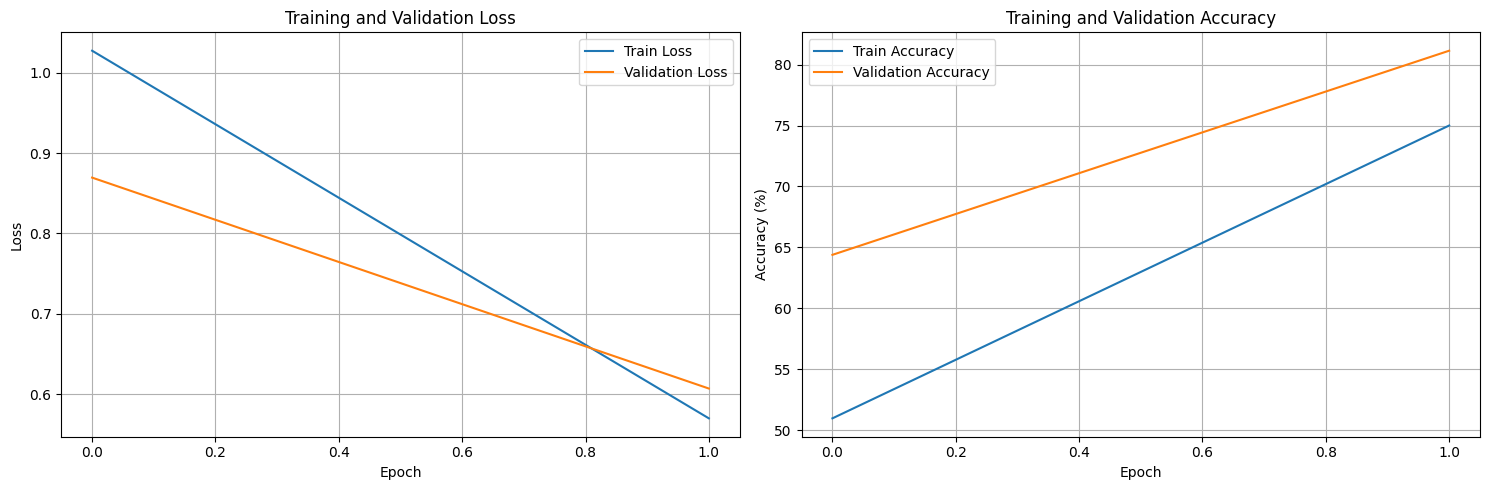

In [ ]:
# VISUALIZING RESULTS

# Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# EVALUATION ON TEST SET

# model.load_state_dict(torch.load('best_ecg_model.pth'))
model.eval()

y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probabilities.cpu().numpy())


📊 OVERALL TEST ACCURACY: 83.83%

PER-CLASS PERFORMANCE
Normal                        : 15011/18118 correct ( 82.85%)
Supraventricular              :  395/ 556 correct ( 71.04%)
Ventricular                   : 1292/1448 correct ( 89.23%)
Fusion                        :  144/ 162 correct ( 88.89%)
Unclassifiable                : 1511/1608 correct ( 93.97%)

CONFUSION MATRIX


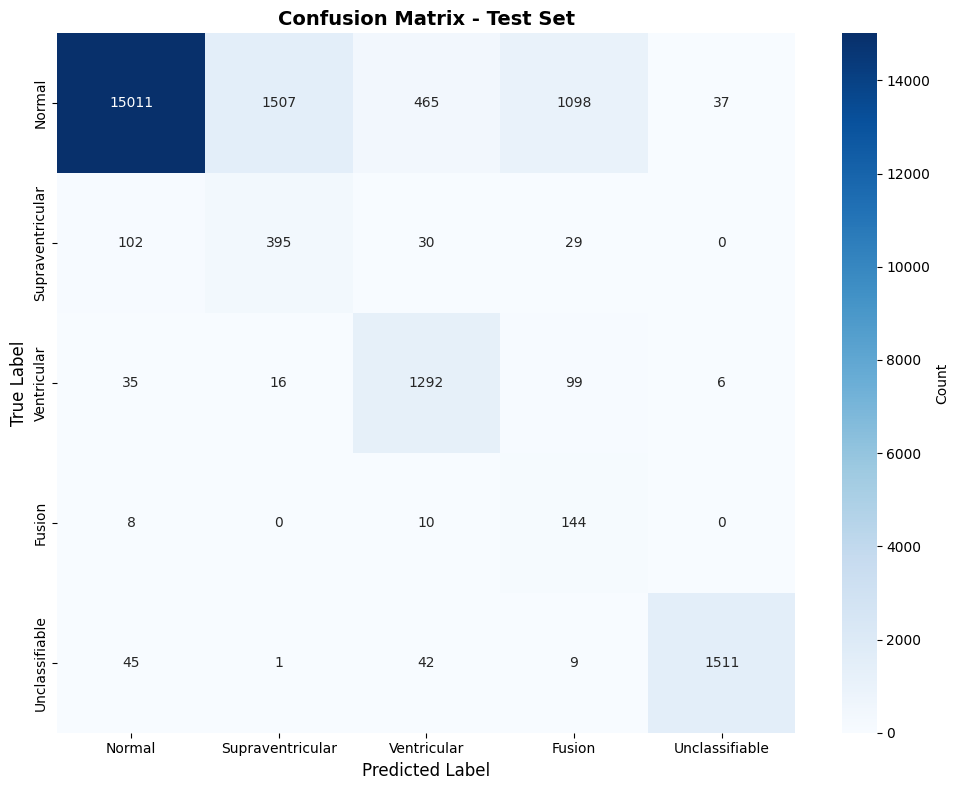

In [ ]:
# Final model evaluation

# model.load_state_dict(torch.load('best_ecg_model.pth'))
model.eval()

y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Overall Accuracy
overall_acc = accuracy_score(y_true, y_pred) * 100
print(f'\n📊 OVERALL TEST ACCURACY: {overall_acc:.2f}%\n')

# Per-class accuracy
print("="*70)
print("PER-CLASS PERFORMANCE")
print("="*70)
for i in range(5):
    class_mask = y_true == i
    class_acc = accuracy_score(y_true[class_mask], y_pred[class_mask]) * 100
    class_total = np.sum(class_mask)
    class_correct = np.sum((y_true[class_mask] == y_pred[class_mask]))
    print(f"{class_names[i]:30s}: {class_correct:4d}/{class_total:4d} correct ({class_acc:6.2f}%)")

# Confusion Matrix
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Additional metrics
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print("AGGREGATE METRICS")
print(f"Weighted Precision: {precision*100:.2f}%")
print(f"Weighted Recall:    {recall*100:.2f}%")
print(f"Weighted F1-Score:  {f1*100:.2f}%")
print(f"Cohen's Kappa:      {kappa:.4f}")

                  precision    recall  f1-score   support

          Normal     0.9875    0.8285    0.9010     18118
Supraventricular     0.2058    0.7104    0.3192       556
     Ventricular     0.7026    0.8923    0.7861      1448
          Fusion     0.1044    0.8889    0.1869       162
  Unclassifiable     0.9723    0.9397    0.9557      1608

        accuracy                         0.8383     21892
       macro avg     0.5945    0.8520    0.6298     21892
    weighted avg     0.9412    0.8383    0.8774     21892

AGGREGATE METRICS
Weighted Precision: 94.12%
Weighted Recall:    83.83%
Weighted F1-Score:  87.74%
Cohen's Kappa:      0.6075


ROC CURVES - MULTICLASS


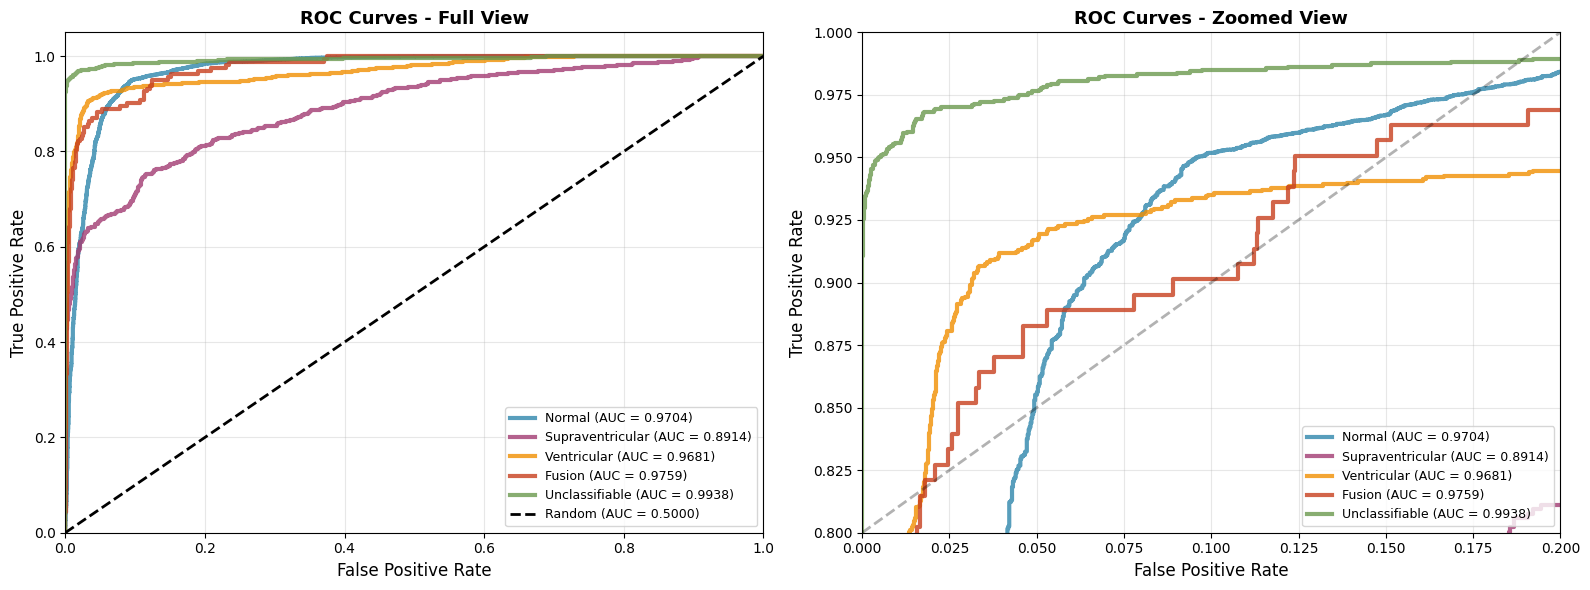

In [ ]:
# ROC Curves for each class
print("ROC CURVES - MULTICLASS")

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC calculation (one-vs-rest)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

# Plot ROC curve for each class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot - Full ROC curves
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
for i in range(5):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color=colors[i], lw=3, alpha=0.8,
             label=f'{class_names[i]} (AUC = {roc_auc:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5000)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves - Full View', fontsize=13, fontweight='bold')
ax1.legend(loc="lower right", fontsize=9)
ax1.grid(alpha=0.3)

# Right plot - Zoomed in (top-left corner) to see differences better
for i in range(5):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color=colors[i], lw=3, alpha=0.8,
             label=f'{class_names[i]} (AUC = {roc_auc:.4f})')

ax2.plot([0, 0.2], [0.8, 1.0], 'k--', lw=2, alpha=0.3)
ax2.set_xlim([0.0, 0.2])  # Zoom to see details
ax2.set_ylim([0.8, 1.0])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves - Zoomed View', fontsize=13, fontweight='bold')
ax2.legend(loc="lower right", fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## NOTES

## Predict new data

In [ ]:
def predict_ecg(model, signal, scaler):
    """
    Prediction on a single ECG signal

    Args:
        model: Trained PyTorch model
        signal: NumPy array of ECG signal (1D)
        scaler: StandardScaler used for normalization

    Returns:
        predicted_class, probabilities
    """
    model.eval()

    # Normalize signal
    signal_scaled = scaler.transform(signal.reshape(1, -1))

    # Convert to tensor
    signal_tensor = torch.FloatTensor(signal_scaled).unsqueeze(1)

    with torch.no_grad():
        output = model(signal_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities.cpu().numpy()[0]

In [ ]:
# Example prediction
sample_signal = X_test[0]
pred_class, probs = predict_ecg(model, sample_signal, scaler)
print(f"\nExample prediction:")
print(f"Predicted class: {pred_class} ({class_names[pred_class]})")
print(f"Probabilities:")
for i, prob in enumerate(probs):
    print(f"  {class_names[i]}: {prob*100:.2f}%")
print(f"True class: {y_test[0]} ({class_names[y_test[0]]})")


Example prediction:
Predicted class: 0 (Normal)
Probabilities:
  Normal: 91.06%
  Supraventricular: 7.08%
  Ventricular: 0.54%
  Fusion: 0.49%
  Unclassifiable: 0.84%
True class: 0 (Normal)


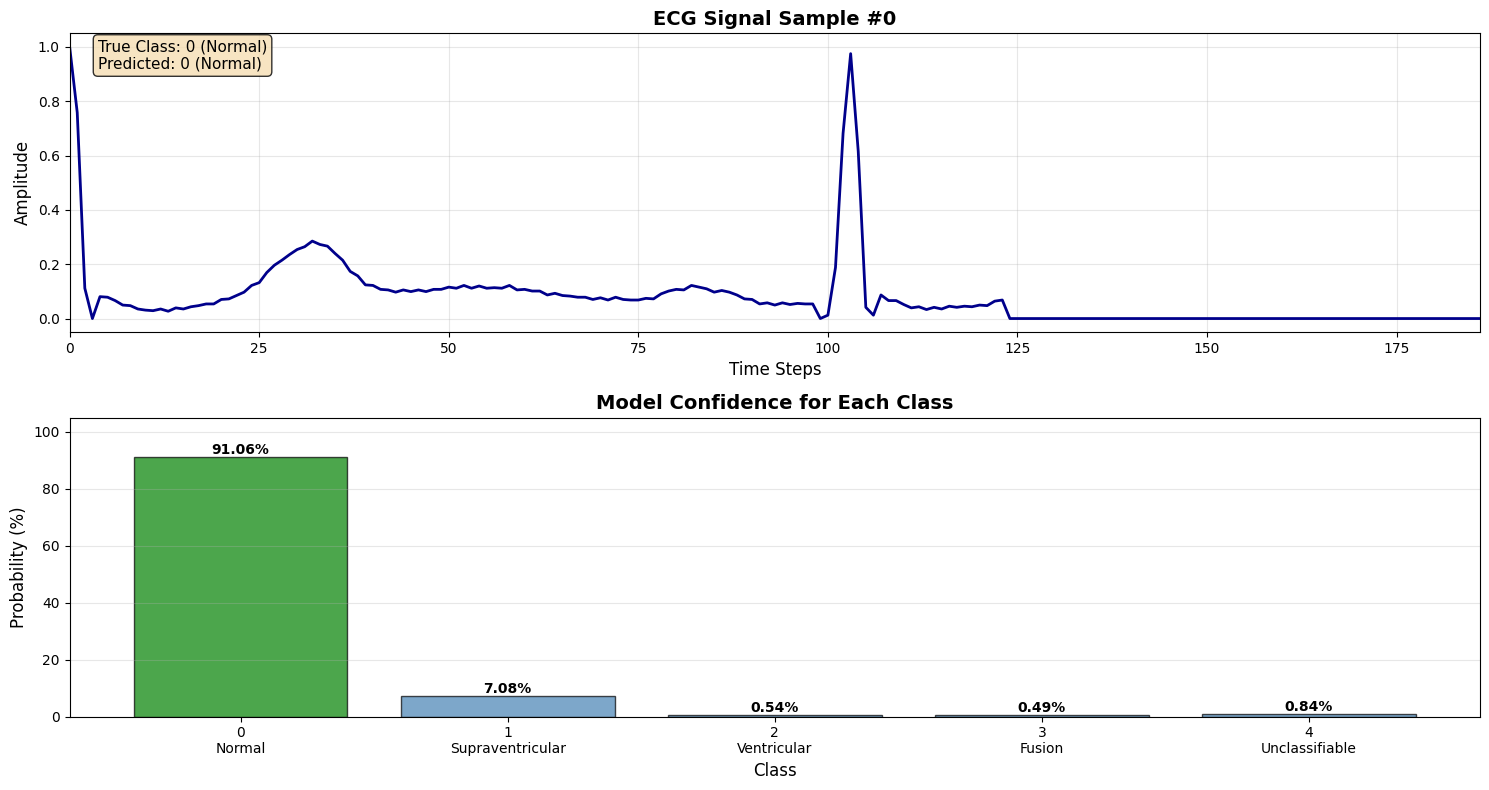


Sample Index: 0
True Class: 0 (Normal)
Predicted Class: 0 (Normal)
Prediction Status: ✅ CORRECT

Probability Distribution:
Normal                        :  91.06%
Supraventricular              :   7.08%
Ventricular                   :   0.54%
Fusion                        :   0.49%
Unclassifiable                :   0.84%


In [ ]:
sample_idx = 0
sample_signal = X_test[sample_idx]
true_label = y_test[sample_idx]

# Make prediction
pred_class, probs = predict_ecg(model, sample_signal, scaler)

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Top plot - ECG Signal
ax1.plot(sample_signal, linewidth=2, color='darkblue')
ax1.set_title(f'ECG Signal Sample #{sample_idx}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Steps', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 186)

# Add prediction and true label as text on the plot
textstr = f'True Class: {true_label} ({class_names[true_label]})\nPredicted: {pred_class} ({class_names[pred_class]})'
props = dict(boxstyle='round', facecolor='wheat' if pred_class == true_label else 'lightcoral', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

# Bottom plot - Prediction Probabilities
colors_bar = ['green' if i == pred_class else 'steelblue' for i in range(5)]
bars = ax2.bar(range(5), probs * 100, color=colors_bar, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Probability (%)', fontsize=12)
ax2.set_title('Model Confidence for Each Class', fontsize=14, fontweight='bold')
ax2.set_xticks(range(5))
ax2.set_xticklabels([f'{i}\n{class_names[i]}' for i in range(5)], rotation=0)
ax2.set_ylim(0, 105)
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (bar, prob) in enumerate(zip(bars, probs)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{prob*100:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed results
print(f"\n{'='*70}")
print(f"Sample Index: {sample_idx}")
print(f"True Class: {true_label} ({class_names[true_label]})")
print(f"Predicted Class: {pred_class} ({class_names[pred_class]})")
print(f"Prediction Status: {'✅ CORRECT' if pred_class == true_label else '❌ INCORRECT'}")
print(f"\nProbability Distribution:")
for i, prob in enumerate(probs):
    print(f"{class_names[i]:30s}: {prob*100:6.2f}%")
